Load dataset

In [1]:
import pandas as pd

data_path = 'Walmart.csv'
walmart_data = pd.read_csv(data_path)
print(walmart_data)

      Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0         1  05-02-2010    1643690.90             0        42.31       2.572   
1         1  12-02-2010    1641957.44             1        38.51       2.548   
2         1  19-02-2010    1611968.17             0        39.93       2.514   
3         1  26-02-2010    1409727.59             0        46.63       2.561   
4         1  05-03-2010    1554806.68             0        46.50       2.625   
...     ...         ...           ...           ...          ...         ...   
6430     45  28-09-2012     713173.95             0        64.88       3.997   
6431     45  05-10-2012     733455.07             0        64.89       3.985   
6432     45  12-10-2012     734464.36             0        54.47       4.000   
6433     45  19-10-2012     718125.53             0        56.47       3.969   
6434     45  26-10-2012     760281.43             0        58.85       3.882   

             CPI  Unemployment  
0     

We only analyze store 36

In [5]:
store_data = walmart_data[walmart_data['Store']==36]

store_data.loc[:, 'Date'] = pd.to_datetime(store_data['Date'], format='%d-%m-%Y')
store_data = store_data.copy()
store_data['Date'] = pd.to_datetime(store_data['Date'], format='%d-%m-%Y')
store_data.set_index('Date', inplace=True)

# Separate train and test data
split_point = int(len(store_data) * 0.8)  # 80% for training, 20% for testing
train_data = store_data.iloc[:split_point]
test_data = store_data.iloc[split_point:]

print(store_data)
print(train_data)

            Store  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
Date                                                                     
2010-02-05     36     467546.74             0        45.97       2.545   
2010-02-12     36     469563.70             1        46.11       2.539   
2010-02-19     36     470281.03             0        45.66       2.472   
2010-02-26     36     447519.44             0        50.87       2.520   
2010-03-05     36     480203.43             0        51.33       2.574   
...           ...           ...           ...          ...         ...   
2012-09-28     36     270677.98             0        79.49       3.660   
2012-10-05     36     277137.86             0        73.57       3.611   
2012-10-12     36     300236.85             0        71.28       3.576   
2012-10-19     36     287360.05             0        74.06       3.570   
2012-10-26     36     272489.41             0        74.39       3.494   

                   CPI  Unemployment 

We plot the Weekly Sales to visualize its behaviour and perform statistical decomposition

Text(0.5, 1.0, 'Residuals')

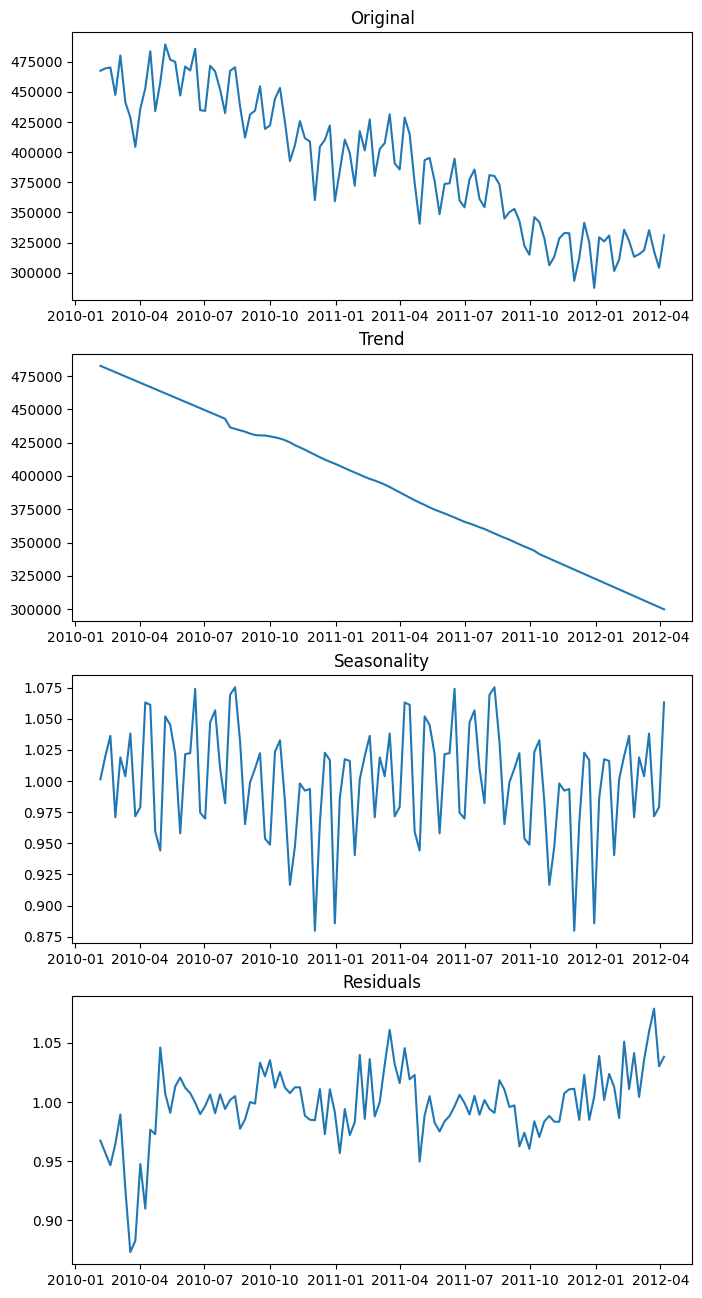

In [6]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series into trend, seasonality, and residual
decomposition = seasonal_decompose(train_data['Weekly_Sales'], extrapolate_trend='freq', model='multiplicative')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(8, 16))
plt.subplot(411)
plt.plot(train_data['Weekly_Sales'], label='Original')
plt.title('Original')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.title('Trend')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.title('Seasonality')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.title('Residuals')

Before determining p, we normalize the weekly sales

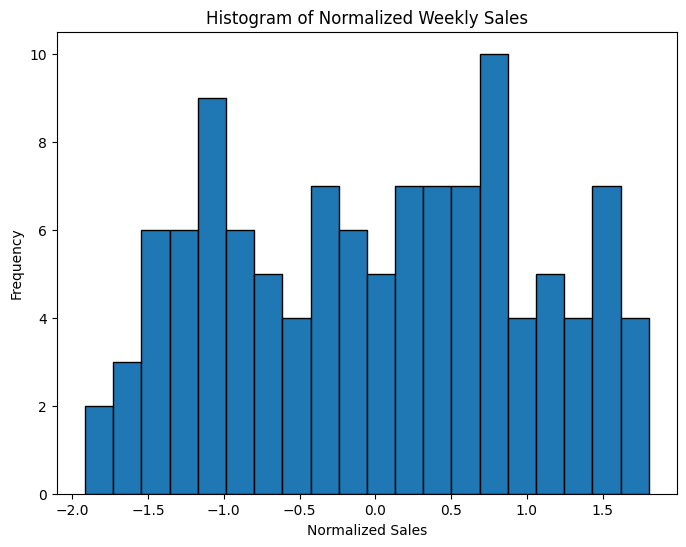

In [8]:
mean_sales = train_data['Weekly_Sales'].mean()
std_sales = train_data['Weekly_Sales'].std()

weekly_sales = (train_data['Weekly_Sales'] - mean_sales) / std_sales

plt.figure(figsize=(8, 6))
plt.hist(weekly_sales, bins=20, edgecolor='black')
plt.title(f'Histogram of Normalized Weekly Sales')
plt.xlabel('Normalized Sales')
plt.ylabel('Frequency')
plt.show()

We now try to determine p with PACF

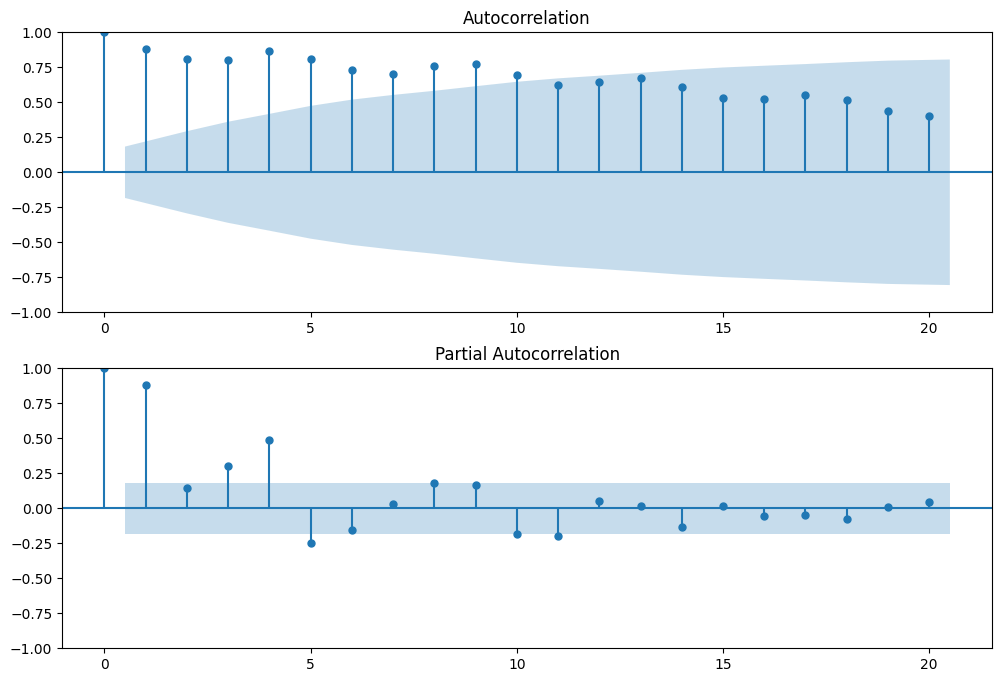

In [9]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))
sm.graphics.tsa.plot_acf(weekly_sales, lags=20, ax=ax1)
sm.graphics.tsa.plot_pacf(weekly_sales, lags=20, ax=ax2)
plt.show()

Normalize exogenous variables

In [10]:
mean_temp = train_data['Temperature'].mean()
std_temp = train_data['Temperature'].std()
normalized_temp = (train_data['Temperature'] - mean_temp) / std_temp

mean_fuel = train_data['Fuel_Price'].mean()
std_fuel = train_data['Fuel_Price'].std()
normalized_fuel = (train_data['Fuel_Price'] - mean_fuel) / std_fuel

mean_cpi = train_data['CPI'].mean()
std_cpi = train_data['CPI'].std()
normalized_cpi = (train_data['CPI'] - mean_cpi) / std_cpi

mean_unem = train_data['Unemployment'].mean()
std_unem = train_data['Unemployment'].std()
normalized_unem = (train_data['Unemployment'] - mean_unem) / std_unem

Recursive Least Squares (RLS) Algorithm

In [11]:
import numpy as np

class RecursiveLeastSquares:
    def __init__(self, p, r, len_x, lambda_forget=0.99, delta=1000):
        self.p = p
        self.r = r
        self.len_x = len_x
        self.lambda_forget = lambda_forget
        self.delta = delta
        self.initialize_parameters()

    def initialize_parameters(self):
        len_f = self.p + self.len_x * self.r
        self.theta = np.zeros(len_f)
        self.f = np.zeros(len_f)
        self.P = self.delta * np.eye(len_f)

    def update(self, y_t, y_past, x_past):

        self.f = np.concatenate([y_past, x_past])

        y_pred = np.dot(self.theta, self.f)
        error = y_t - y_pred

        # Compute the gain
        g = np.dot(self.P, self.f) / (self.lambda_forget + np.dot(self.f.T, np.dot(self.P, self.f)))

        # Update the estimate
        self.theta += g * error

        # Update the error covariance matrix
        self.P = (self.P - np.dot(g, self.f.T * self.P)) / self.lambda_forget

        return self.theta, error

C:\Users\inigo\AppData\Local\Temp\ipykernel_2736\1543724004.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  theta, error = rls.update(y[t], y_past, x_past)
C:\Users\inigo\AppData\Local\Temp\ipykernel_2736\1543724004.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat[t] = y[t] - error


MSE: 0.8260041280322
[-0.07408599 -0.04930294 -0.03696972  0.11916741 -0.02354216 -0.16342753
 -0.37501774 -0.31693239 -0.31900982 -0.01749752]


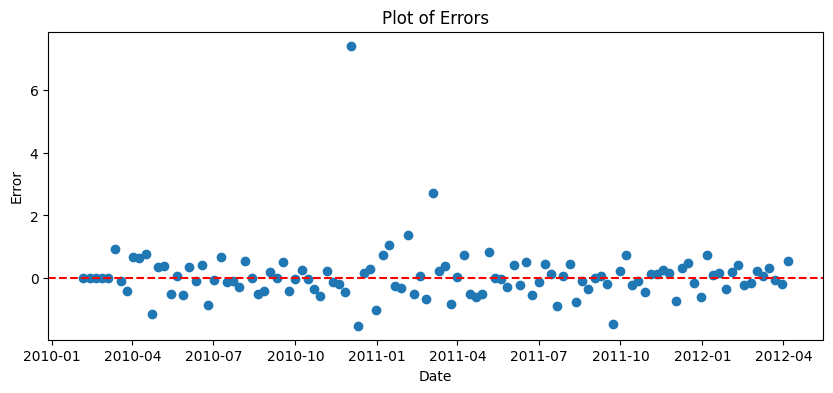

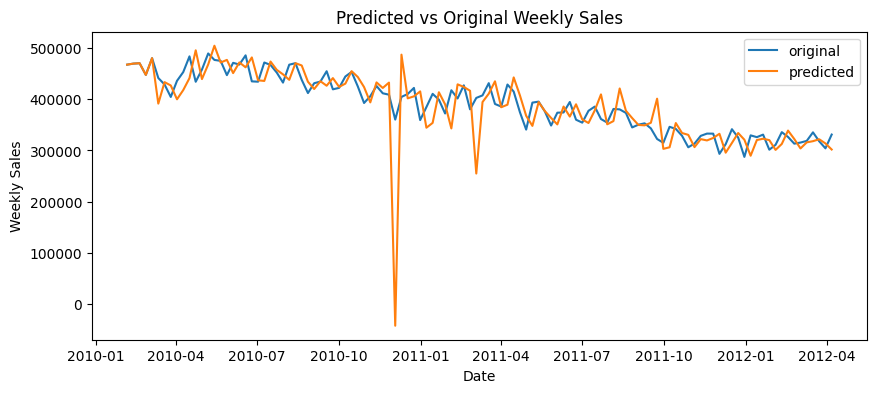

In [12]:
p = 5  # Number of AR terms
len_x = 5  # Number of exogenous variables
r = 1  # Lags for exogenous variables
rls = RecursiveLeastSquares(p, r, len_x)

start_index = max(p, r)

y = weekly_sales
yhat = np.zeros(len(weekly_sales))
yhat[:start_index] = y[:start_index]

e = np.zeros(len(weekly_sales))

x = np.column_stack((train_data['Holiday_Flag'], normalized_temp, normalized_fuel, normalized_cpi, normalized_unem))


for t in range(start_index, len(weekly_sales)):
    y_past = y[t-p:t][::-1]
    x_past = []
    for i in range(r, 0, -1):
        x_past = np.concatenate((x_past, x[t-i]))

    theta, error = rls.update(y[t], y_past, x_past)
    yhat[t] = y[t] - error
    e[t] = error  

mse = np.sum(np.square(e[start_index:])) / (len(weekly_sales) - start_index)
print("MSE:", mse)
print(theta)

# Denormalize

yhat_denorm = yhat*std_sales + mean_sales

# Plot errors
plt.figure(figsize=(10, 4))
plt.plot(train_data.index, e, marker='o', linestyle='')
plt.title('Plot of Errors')
plt.xlabel('Date')
plt.ylabel('Error')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(train_data.index, train_data['Weekly_Sales'], label='original')
plt.plot(train_data.index, yhat_denorm, label='predicted')
plt.title('Predicted vs Original Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

Test phase

Normalize variables

In [13]:
mean_test_sales = test_data['Weekly_Sales'].mean()
std_test_sales = test_data['Weekly_Sales'].std()
weekly_sales_test = (test_data['Weekly_Sales'] - mean_test_sales) / std_test_sales

mean_test_temp = test_data['Temperature'].mean()
std_test_temp = test_data['Temperature'].std()
normalized_test_temp = (test_data['Temperature'] - mean_test_temp) / std_test_temp

mean_test_fuel = test_data['Fuel_Price'].mean()
std_test_fuel = test_data['Fuel_Price'].std()
normalized_test_fuel = (test_data['Fuel_Price'] - mean_test_fuel) / std_test_fuel

mean_test_cpi = test_data['CPI'].mean()
std_test_cpi = test_data['CPI'].std()
normalized_test_cpi = (test_data['CPI'] - mean_test_cpi) / std_test_cpi

mean_test_unem = test_data['Unemployment'].mean()
std_test_unem = test_data['Unemployment'].std()
normalized_test_unem = (test_data['Unemployment'] - mean_test_unem) / std_test_unem

Run test

C:\Users\inigo\AppData\Local\Temp\ipykernel_2736\656042523.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  e_test[t] = y_test[t] - yhat_test[t]


Test MSE: 1.062756739637994


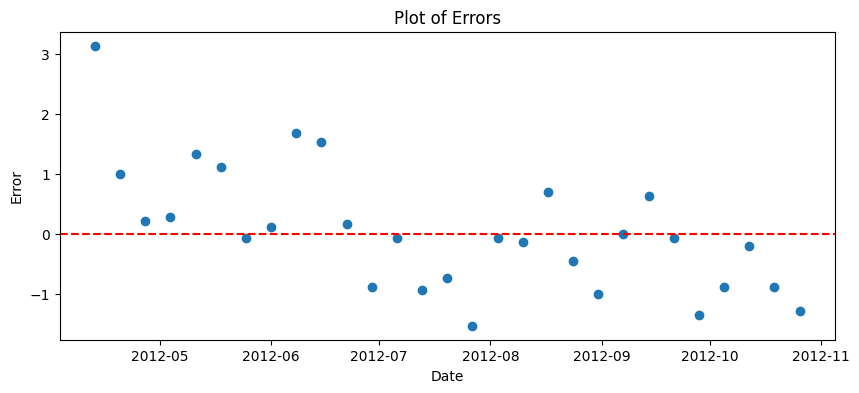

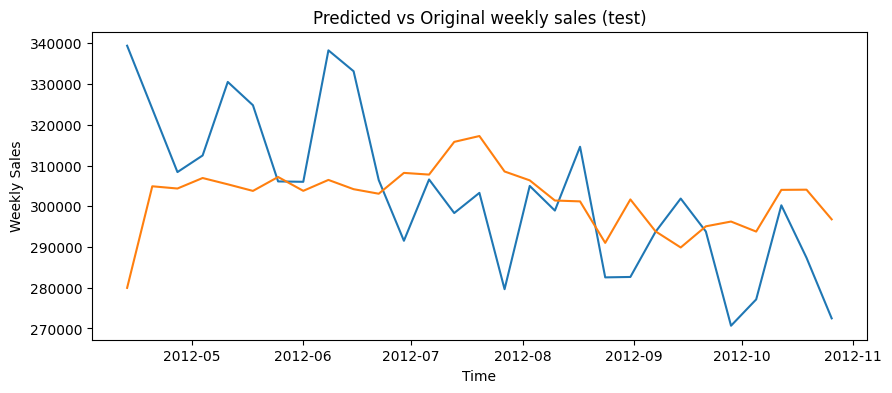

In [14]:
y_test = weekly_sales_test
x_test = np.column_stack((test_data['Holiday_Flag'], normalized_test_temp, normalized_test_fuel, normalized_test_cpi, normalized_test_unem))

yhat_test = np.zeros(len(weekly_sales_test))
e_test = np.zeros(len(weekly_sales_test))

all_y = np.concatenate((y[-p:], y_test))
all_x = np.vstack((x[-r:], x_test))

for t in range(len(weekly_sales_test)):
    y_past_test = all_y[t:t+p][::-1]
    x_past_test = []
    for i in range(r, 0, -1):
        x_past_test = np.concatenate((x_past_test, all_x[t+i-1]))
    f = np.concatenate([y_past_test, x_past_test])
    yhat_test[t] = np.dot(theta, f)
    e_test[t] = y_test[t] - yhat_test[t]

mse_test = np.sum(np.square(e_test)) / (len(e_test))
print("Test MSE:", mse_test)

yhat_test_denorm = yhat_test*std_test_sales + mean_test_sales

# Plot of erros
plt.figure(figsize=(10, 4))
plt.plot(test_data.index, e_test, marker='o', linestyle='')
plt.title('Plot of Errors')
plt.xlabel('Date')
plt.ylabel('Error')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(test_data.index, test_data['Weekly_Sales'], label='original')
plt.plot(test_data.index, yhat_test_denorm, label='predicted')
plt.title('Predicted vs Original weekly sales (test)')
plt.xlabel('Time')
plt.ylabel('Weekly Sales')
plt.show()